# Lecture 4 GA2048
# Root Finding, Integration, Function Representation

## Topics:

* Root finding
    - Bisection
    - Secant
    - Newton-Ralphson
    - Brent
* Convergence Acceleration
    - Kummer's transformation
    - Euler's transform
    - Aitken method
* Numerical Integration
    - Riemann sums, Trapezoid and Simpson Rules
    - Gaussian Quadratures
* Function Representation: Approximation vs Interpolation
    - Taylor expansions, asymptotic expansions
    - Functional representation: (Non-Linear) Least Square, Neural-Nets
    - Fourier Series, Wavelets
    - Neural Nets
* Global interpolation: Lagrange, Hermite Polynomials
* Piecewise polynomial interpolation
    - Cubic spline
    - Hermite cubic splines
    - Tension Splines
* Parametric Representation
    
$\renewcommand{bt}[1]{\tilde{\boldsymbol #1}}$
$\renewcommand{bs}{\boldsymbol} \renewcommand{var}{\text{var}} \renewcommand{std}{\text{std}} \renewcommand{cov}{\text{cov}}$
$\newcommand{\eps}{\varepsilon} \renewcommand{\s}{\sigma} \newcommand{\E}{\mathbb{E}} \newcommand{\P}{\mathbb{P}}$
$\newcommand{\F}{\mathcal{F}} \newcommand{\half}{\frac{1}{2}} \newcommand{\R}{\mathbb{R}} \newcommand{\Z}{\mathbb{Z}} $
$\newcommand{\w} {\omega} \newcommand{\l} {\ell} \newcommand{\lbd} {\lambda} \renewcommand{\S}{\Sigma}$ 
$\newcommand{\a} {\alpha} $
$\newcommand{\Z} {\mathbb{Z}} $
$\newcommand{\vphi}{\varphi}$

In [6]:
%pylab inline
import scipy.optimize as opt
from scipy.stats import norm
import pandas as pd

from scipy.interpolate import CubicSpline, PchipInterpolator, CubicHermiteSpline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\msont\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [1]:
import os
import sys

cwd = os.getcwd()
sys.path.append(cwd + "\\GA2048\\lib\\")
#sys.path.append(cwd + "\\GA2048\\img\\")
#sys.path.append(cwd + "\\GA2048\\data\\")

In [2]:
import interpolation_curve, fmt

# Rootfinding Algorithms

## Common rootfinding methods

Search the root of a scalar function $f(x) = 0$, common methods:

* Bisection
* Secant
* Newton-Ralphson
* Brent

Mathematical analysis needed to ensure one solution exists.<br>
Extending to solve for $f(x) = y$ for a given $y$ is simply done by considering $g(x) = f(x) -y$.<br>
This is also a way to compute the inverse $f^{-1}$ when it exists as $x = f^{-1}(y)$.<br>
Note obviously done in high dimension; an optimization approach would be required to minimize $(f(x)-y)^2$ for which  the solution is not usually unique.

## Illustrative Examples: 

* compute the implied volatility of a call option.
$$ C = S\Phi(d) - K e^{-rt}\Phi\left(d-\sigma \sqrt{t}\right) $$
$$ d = \frac{\log(S/K) + (r+0.5\times\sigma^2)t}{\sigma\sqrt{t}} $$

* a more challenging problem of $\Phi(x) + .05x - 0.5 = 0$

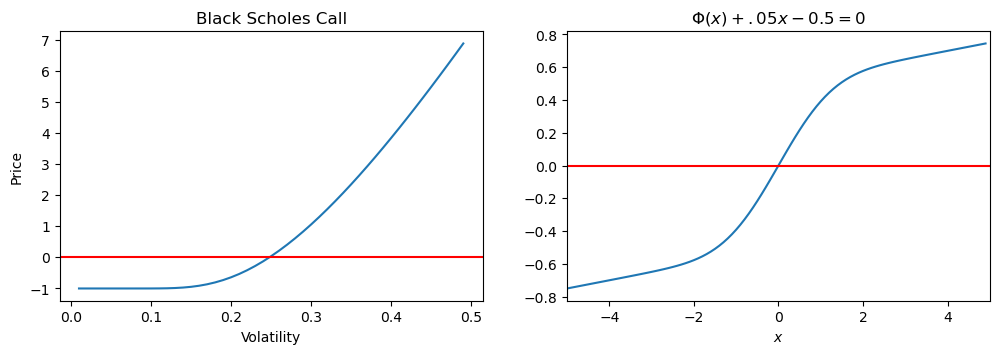

In [7]:
# black scholes call
def bs_call(r, s, k, sigma, t):
    total_vol = sigma*math.sqrt(t)
    F = s*math.exp(r*t)
    d1 = (math.log(F/k))/total_vol + .5*total_vol
    d2 = d1 - total_vol
    return norm.cdf(d1)*s - norm.cdf(d2)*k*math.exp(-r*t)

# black scholes vega
def bs_vega(r, s, k, sigma, t) :
    total_vol = sigma*math.sqrt(t)
    F = s*math.exp(r*t)
    d1 = (math.log(F/k))/total_vol + .5*total_vol
    return math.sqrt(t)*s*norm.pdf(d1)

f = lambda s : bs_call(r=.05, s=100, k=150., sigma=s, t=1)-1
g = lambda s : bs_vega(r=.05, s=100, k=150., sigma=s, t=1) 
f2 = lambda x : norm.cdf(x) + .05*x - .5
g2 = lambda x, a, b : norm.pdf(x) + .05

fig = figure(figsize=[12, 3.5])
subplot(1, 2, 1)
sigs = np.arange(.01, .5, .01)
bsv = np.array([f(s) for s in sigs])
plot(sigs, bsv, '-')
axhline(color = 'r');
xlabel('Volatility')
ylabel('Price');
title('Black Scholes Call')
subplot(1, 2, 2)
x2 = np.arange(-5, 5, .1)
plot(x2, f2(x2));
xlabel('$x$')
axhline(color = 'r')
xlim(-5, 5)
title('$\Phi(x) + .05x - 0.5 = 0$');

## Bisection

* Initial guess must bucket the solution: find $x\in [a,b]$ such that $f(x) = 0$, given
  * $f(a)*f(b) \leq 0$
* The function must be continuous
* Converges to a root linearly (absolute error halves for each iteration).
  * $\epsilon_{n+1} \le c \epsilon_n^q, \;\epsilon_n = \left| x_n - x_{root}\right|,\; q=1, \;c=\frac{1}{2}$

In [8]:
def cumf (x, func, xs) :
    xs.append(x)
    return func(x)

def show_converge(f, xs, a, b, maxIter, tag, diagline = True, txty = .5) :
    figure(figsize = [12, 3.5])
    subplot(1, 2, 1)

    xr = np.arange(a*.9, b*1.1, (b-a)/500.)
    bsv = np.array(list(map(f, xr)))

    plot(xr, bsv, '-')
    axhline(color = 'k');

    for i in range(maxIter) :
        plot([xs[i], xs[i]], [0, f(xs[i])])
        scatter(xs[i], txty*(1. if f(xs[i]) < 0 else -1.), s=150, marker = "$%d$"% i)
        if diagline and i< (maxIter-1):
            plot([xs[i], xs[i+1]], [f(xs[i]), 0])

    xlim(a*.9, b*1.1);
    ylim(f(a) - .2, f(b) + .2);
    xlabel('$x$')
    ylabel('$f(x)$')
    title(tag)

    subplot(1, 2, 2)
    es = np.abs(list(map(f, xs)))
    semilogy(es, '.');
    xlabel('Iterations')
    title('Error');

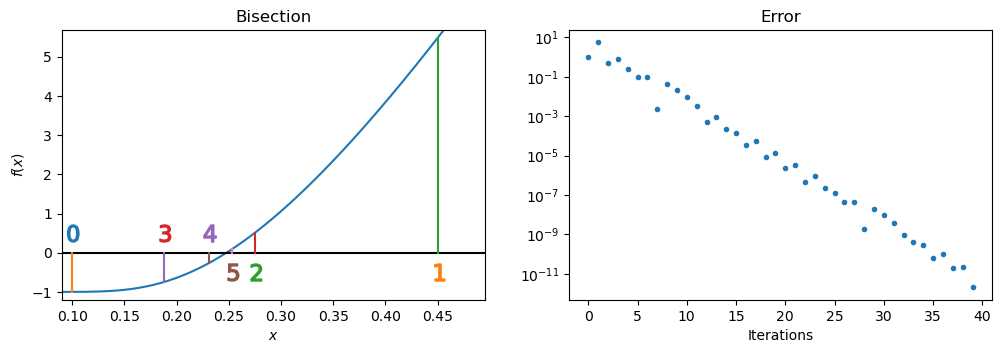

In [9]:
a = .1
b = .45
    
xs = []
nx = opt.bisect(cumf, a, b, args=(f, xs))
show_converge(f, xs, .1, .45, 6, 'Bisection', False)

## Secant

* Uses the secant line to find successive approximation

$$ x_n = x_{n-1} - f(x_{n-1})\frac{x_{n-1} - x_{n-2}}{f(x_{n-1}) - f(x_{n-2})} $$

* Converges faster than Bisection method with $\epsilon_{n+1} \le c\epsilon_n^q, \; q\approx 1.618 $
* Can be thought of as poor man's choice of the Newton's method --- also referred to as a quasi-Newton method.
 

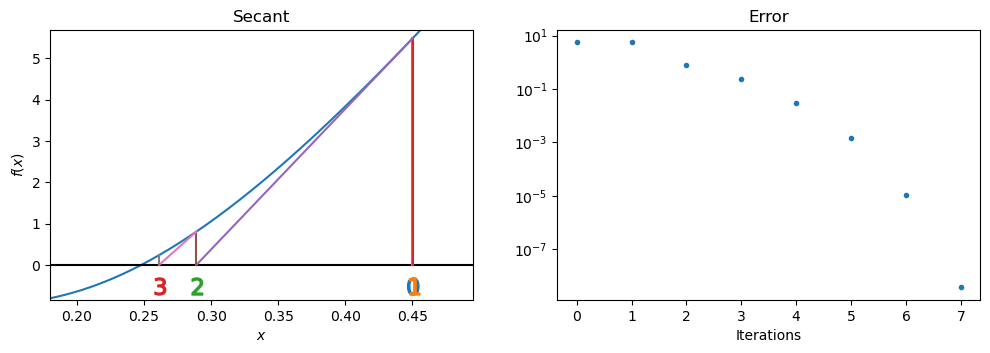

In [10]:
xs = []
g = lambda s, foo, bar: bs_vega(r=.05, s=100, k=150., sigma=s, t=1) 
nx = opt.newton(cumf, b, args=(f, xs))

show_converge(f, xs, 0.2, .45, 4, 'Secant', True)

* Secant method is not guaranteed to converge. 
* Suffers for wiggly functions with small/vanishing derivative.
* Sometimes used in the alternative form
$$ x_n = x_{n-1} - f(x_{n-1})\frac{h}{f(x_{n-1}+h)-f(x_{n-1})} $$
where $h$ is chosen fixed and in order to help improve stability of the approximate gradient.

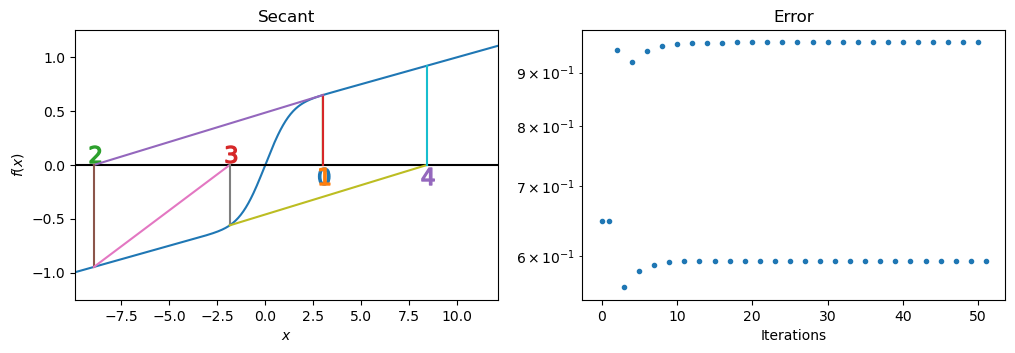

In [11]:
xs = []
try : 
    nx = opt.newton(cumf, 3, args=(f2, xs))
except RuntimeError:
    pass

show_converge(f2, xs, -11, 11, 5, 'Secant', True, .1)

## Newton-Ralphson


* Use first derivative to approximate the root

$$ x_n = x_{n-1} - \frac{f(x_{n-1})}{f'(x_{n-1})} $$

* converges quadratically: $\epsilon_{n+1} \le c\epsilon_n^q,\; q=2$.

* intuition is to approximate $f(x)$ around $f(x_n)$ with it's tangent line $f'(x_n)(x-x_n)+f(x_n)$ and choosing the next point where the tangent line crosses the x-axis.

* convergence is not guaranteed, it can fail around inflection point. 
* guaranteed convergence if the function is convex everywhere.
* need to be careful around points where the derivative vanishes.

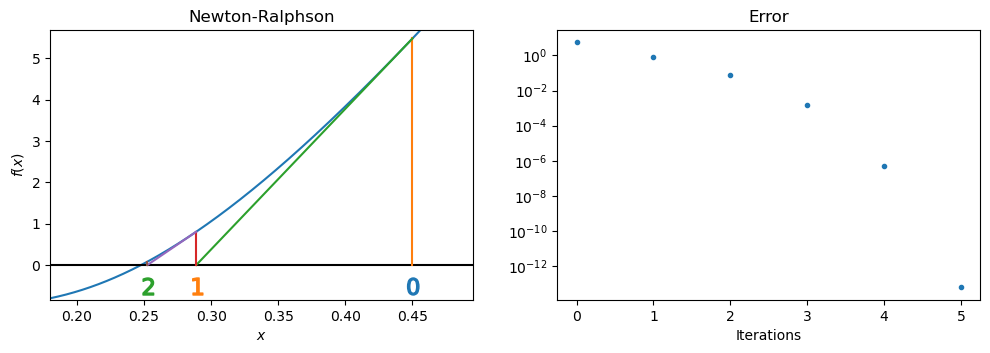

In [12]:
xs = []
nx = opt.newton(cumf, b, g, args=(f, xs))
#nx = opt.newton(f, x0=b, fprime=g,)# args=(f, xs))

show_converge(f, xs, 0.2, .45, 3, 'Newton-Ralphson', True)

## Brent
* Often the default choice in practice
* An adaptive algorithm---mixes root bracketing, bisection and
* Inverse quadratic interpolation (Secant uses linear interpolation)
* Guaranteed to find a solution if initial guesses bucket the root
* Usually converges very fast $\epsilon_{n+1} \le c\epsilon_n^q, \; q \approx 1.839$.

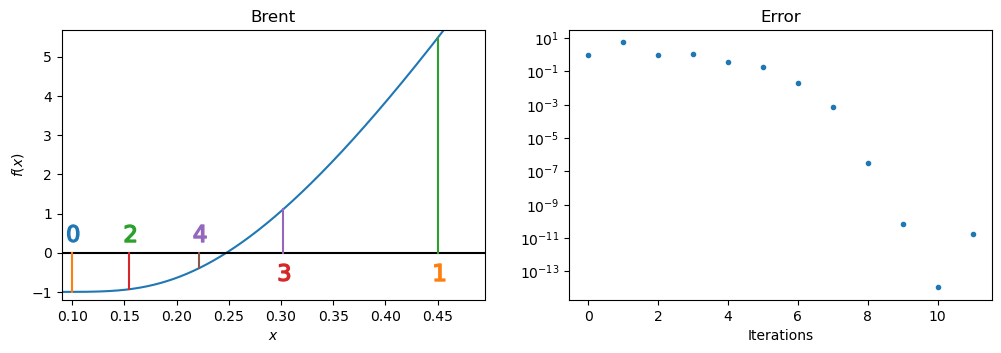

In [13]:
xs = []
g = lambda s : bs_vega(r=.05, s=100, k=150., sigma=s, t=1) 
nx = opt.brentq(cumf, a, b, args=(f, xs))

show_converge(f, xs, 0.1, .45, 5, 'Brent', False)

The challenging $\Phi(x) + .05x - 0.5 = 0$ converges under Brent:

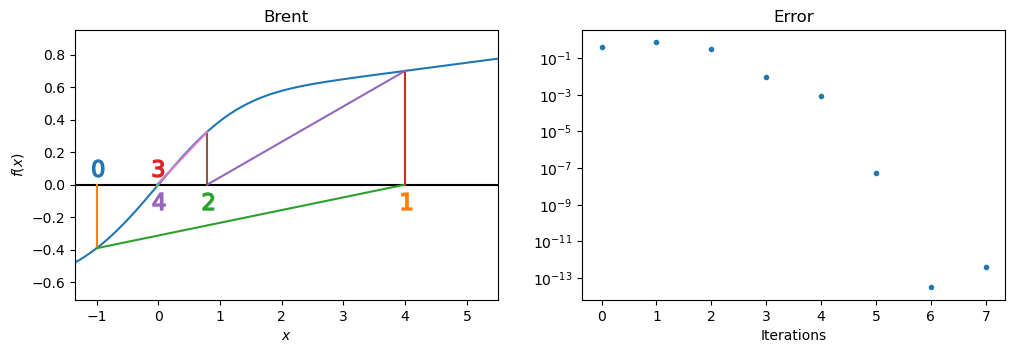

In [14]:
xs = []
nx = opt.brentq(cumf, -1, 4, args=(f2, xs))

show_converge(f2, xs, -1.5, 5, 5, 'Brent', True, .1)

# Convergence Acceleration

If $x_n \to \ell$, then a sequence $s_n$ is a convergence acceleration if $ \frac{s_n - \ell}{x_n - \ell} \to 0$. The sequence $s_n$ is usually obtained from transforming the original sequence $x_n$ in a non-trivial way, usually using only a very limited of extra points (e.g. $s_n = x_{n^2}$ is not what would be considered yielding a convergence acceleration, even when it statisfies the condition of the definition)

## Kummer's Transform
Let's consider the objective of computing $\sum_{n=0}^{+\infty} a_n$, but the convergence is slow. If we happen to have the following ingredients:
- We know an explicit/analytic expression for $\beta = \sum_{n=0}^{+\infty} b_n$.
- $\lim_n a_n/b_n = \gamma \neq 0$

then
$$ \sum_{n=0}^{+\infty} a_n = \gamma \beta + \sum_{n=0}^{+\infty} (a_n-\gamma b_n)$$

Note the ressemblance with a control variate in Monte Carlo reduction technique. The condition $\lim_n a_n/b_n = \gamma \neq 0$ guarantees that the $a_n$ and $b_n$ are "highly correlated", yielding a convergence acceleration.

## Euler's Transform
To compute $\sum_{n=0}^{+\infty} (-1)^n a_n$, one uses the relationship
$$ \sum_{n=0}^{+\infty} (-1)^n a_n = \sum_{n=0}^{+\infty} (-1)^n \frac{\sum_{k=0}^n (-1)^k \left(_k^n \right)a_{n-k}}{2^n} $$

Note that
$\sum_{k=0}^n (-1)^k \left( _k^n \right)a_{n-k} = (\Delta^n a)_0 $ is the repeted difference $n$ times (so no need to actually compute binomial coefficients).


## Aitken Method

$$ s_n = x_n + \frac{(x_{n+1} - x_n)^2}{x_{n+2} - 2 x_{n+1} + x_n} = x_n + \frac{(\Delta x_n)^2}{\Delta^2 x_n}$$


# Numerical Integration

## Quadrature rules

To compute the definite integral of a one dimensional function:

$$ \int_a^b f(x) dx $$

* Rectangle rule: $ \int_a^b f(x) dx \approx (b-a)f(b) $
* Trapezoidal rule:  $ \int_a^b f(x) dx \approx (b-a)\frac{f(a) + f(b)}{2} $
* Simpson's rule: $\int_a^b f(x) dx \approx \frac{b-a}{6}[f(a) + 4 f(\frac{a+b}{2}) + f(b)] $
* Gaussian Quadrature: $ \int_a^b f(x) dx \approx \sum_{i=1}^{N} w_i \;f(x_i) $, where the nodes $x_i$ and weights $w_i$ are fixed numerical constant. [Gaussian quadratures](https://en.wikipedia.org/wiki/Gaussian_quadrature) are of many different kind depending on the integral under consideration. 

In practice:
* The Simpson's rule works well for reasonably smooth functions defined on a finite interval.
* When the interval is inifinite a change a variable can be useful with a smart left/right rectangular rule (to avoid calling the function where is not well defined).
* When the integrand has a singularity at a boundary, yet the integral is known to converged, a change of variable can also be useful , or a quadrature that avoid selecting points to close to the singularity can help.
* When integrating over a Gaussian Kernel, the [Gauss-Hermite](https://en.wikipedia.org/wiki/Gauss%E2%80%93Hermite_quadrature) is the prefered approach in practice.
* Adaptive methods can be used to achieve a desired level of accuracy. Error estimates are used to control the order at which the quadrature can stop. see for instance the [Gauss-Kronrod quadrature](https://en.wikipedia.org/wiki/Gauss%E2%80%93Kronrod_quadrature_formula) which can be used from [scipy.integrate.quad_vec](https://scipy.github.io/devdocs/generated/scipy.integrate.quad_vec.html)

## Accuracy of numerical integration

If the interval $[a, b]$ is divided into $N$ equal steps, then the numerical errors of the $\int_a^b f(x) dx$ for smooth function $f(x)$ are:

| Rectangle | Trapezoidal | Simpson |
| :-----: | :------: | :------: |
| $O\Big(\frac{1}{N}\Big)$ | $O\Big(\frac{1}{N^2}\Big)$ | $O\Big(\frac{1}{N^4}\Big)$ |

For Gaussian quadratures, nodes $x_i$ and weights $w_i$ are chosen so that the integral is exact for polynomials of degrees upto order $2N-1$.

## Truncation and Singularities

Take $\alpha > 0$ and $f$ with enough regularity:
$$ \int_0^{+\infty} f(x)dx = \alpha \int_0^{1} f\left(\alpha \frac{x}{1-x}\right) \frac{1}{(1-x)^2}dx   $$

When numerically computing $\int_a^b f(x)dx$ with $a$ or $b$ we have either $\lim_{x\to a} f(x) = +\infty$ or $\lim_{x\to b} f(x) = +\infty$ while having the, it is important to either truncate the integral to $\int_{a+\epsilon_a}^{b-\epsilon_b} f(x)dx$ with controling the error, or perform an expansion of $f$ and compute/approximate $\int_a^{a+\epsilon_a} f(x)dx$ (similar for the other side) analytically.

For instance, if $f(x) \sim a x^{-\half}$ as $x \to 0$, then
$$\int_0^1 f(x) dx \sim a \int_0^{\eps} x^{-\half}dx + \int_{\eps}^{1} f(x) dx $$



Then, how do we choose $\eps$ ?
- Need to avoid under/overflow: $a\sim 10^k$ and $\eps \sim 10^{-n}$ then $a \eps^{-\half} \sim 10^{k+n/2}$.
- Need to control accuracy: $a\int_0^{\eps} x^{-\half}dx = 2a \sqrt{\eps} = O\left(\sqrt{\eps}\right)$.




## Controlling the Integration Error

### Finite Interval

Let's consider an integral of the form $\int_0^1 f(x)g(x) dx$ where $\lim_{x \to 0} f(x) = +\infty$ but still $\lim_{x \to 0} f(x) g(x) = 0$, and let's assume both functions are well behaved (e.g. bounded) around $x=1$ so that the integral is well defined.

Let's consider we want to achieve an accuracy level of $\epsilon$. We need to choose $\delta > 0$ so that $\left |\int_0^\delta f(x) g(x) dx \right| \leq \epsilon$. From $\left |\int_0^\delta f(x) g(x) dx \right| \leq  \int_0^\delta \left | f(x) g(x) \right| dx $ we can assume that $f$ and $g$ are positive.

Since $f(x)g(x) \to 0$, it means that $f(x)g(x)$ will be decreasing at some point. Unless $f(x) g(x)$ is really strangely behaved, we can usually find a $ \delta >0$ such that $f(x) g(x) \leq f( \delta) g( \delta) = B$. Then $ \int_0^\delta f(x)g(x) dx \leq \delta f(\delta) g(\delta)$. It then suffices to have $\delta f(\delta) g(\delta) \leq \epsilon$.

The number $ \delta$ can be usually found empirically with a few attempts or estimated analytically depending on the problem at hand.

The above reasoning shows that if we know that $|f(x) g(x)|$ only remains bounded around $x=0$, i.e. $|f(x) g(x)| \leq M$ for $x \leq \tilde \delta$ with $\delta \leq \tilde \delta$, then we need to choose $\delta$ such that $\delta \times M \leq \epsilon$.

Note that it is always important to make sure that $f(\delta) g(\delta)$ will not create an overflow.


### Inifinite Interval
For integrals of the form (for instance) $\int_0^{+\infty} f(x) dx$, we can perform a change of variable, as previously explained, that will change the infinite integration interval to a finite one. Care is still needed as the overflow because for instance if the last integration point over $[0, 1]$ is $x = 1- \eps$, then the function $f$ needs to be evaluated at the boundary point $\frac{x}{1-x} = \frac{1-\eps}{\eps} = \frac{1}{\eps} -1$.

For a small $\eps$, $f(\frac{1}{\eps} -1)$ could overflow.

In this type of case, the change of variable and the integration technique and the related integartion step size will determine the upper truncation boundary $x_{max} = \frac{1}{\eps} -1$ in $\int_0^{+\infty} f(x) dx$.

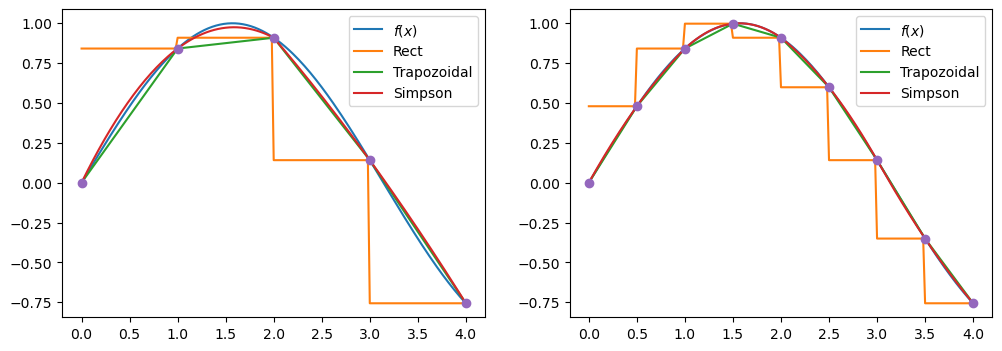

In [15]:
def plotIntegral(f, x, xs, lines) :
    plot(xs, f(xs))
    
    for k, l in lines.items() :
        l.fit(x, f(x))
        plot(xs, l(xs))
        
    legend(['$f(x)$'] + list(lines.keys()), loc='best')

intRules = dict(Rect=interpolation_curve.PiecewiseConstant(), 
                Trapozoidal =interpolation_curve.PiecewiseLinear(), 
                Simpson=interpolation_curve.Quadratic())

f = np.sin
x0 = 0.
x1 = 4.
dx = 2.

x = np.arange(x0, x1 + 1e-10, dx/2)
xs = np.arange(x0, x1 + 1e-10, .02)

figure(figsize=[12, 4])
subplot(1, 2, 1)
plotIntegral(f, x, xs, intRules)
plot(x, f(x), 'o');

subplot(1, 2, 2)
x = np.arange(x0, x1 + 1e-10, dx/4)
plotIntegral(f, x, xs, intRules)
plot(x, f(x), 'o');

# Function Representation: Approximation vs Interpolation
- For a given "unknown" (e.g. non-analytic) function $f$ an approximation is a function $g$ supposed to be "known" (e.g. analytic) such that $f(x) \approx g(x)$ in some sense.

- An interpolation for given (observed) points $(x_i, f(x_i))_{i=1,...,N}$ is an analytical function $g$ such that we can substitute a value $g(x)$ in place of the unknown $f(x)$ for $x \neq x_i$. In general, we require that $g$ satisfies $g(x_i) = f(x_i)$. The interpolation function $g$ is often build with additional properties (e.g. smoothness requirements).


## Function Approximation

The approximation $f(x) \approx g(x)$ can have different meaning depending on the situation:
- Local approximation $\lim_{x\to a} f(x) / g(x) = 1$
- Global approximation $|f(x) - g(x)| \leq M$ $\forall x \in [a,b]$. Note that depending on the size of $[a,b]$, 
- Best approximation in some sense $g = argmin\{||f-h|| \;\; for \; h \in \Omega\}$ where $\Omega$ is a functional set (e.g. some class of function in $L^2$, polynomial or trigonometric) and $f \to ||f||$ is some functional norm.





## Taylor Expansion

$$ f(x) = f(a) + f'(a)(x-a) + ... + \frac{1}{n!}f^{(n)}(a)(x-a)^n + o((x-a)^n) $$

## Asymptotic Expansions

$$ f(x) = a_0\vphi_0(x) + a_1\phi_1(x) + ... + a_N\vphi_N(x) + R_N(x) $$

with $\vphi_{n+1}(x) = o(\vphi_n(x))$ and $\lim_{x\to a}R_N(x) = 0$. We write $f(x) \sim \sum_{k=0}^n a_k \vphi_k(x)$.

Note that in general, the asymptotic representation is not unique. We can have $f \sim \sum_{k=0}^n \vphi_k$ and $g \sim \sum_{k=0}^n \vphi_k$ with $f \neq g$: the residual is (of course) not the same!

**Example**:
$$ \Phi(x) = \frac{1}{\sqrt{2\pi}}\int_{-\infty}^x e^{-\half t^2} dt $$

One easily gets
$$ \Phi(x) = \half + \frac{1}{\sqrt{2\pi}}\int_0^x e^{-\half t^2} dt = \half + \half \frac{2}{\sqrt{\pi}}\int_0^{\frac{x}{\sqrt{2}}} e^{- t^2} dt $$

The error function 
$$ erf(x) = \frac{2}{\sqrt{\pi}}\int_0^{x} e^{- t^2} dt $$

has the following asymptotic development
$$ erf(x) = \frac{e^{-x^2}}{x \sqrt{\pi}} \sum_{n=0}^{N-1} (-1)^n \frac{(2n-1)!!}{(2x^2)^n} + R_N(x) $$

with $R_N(x) = O\left(x^{-1(1+2N)}e^{-x^2} \right)$.

which is useful when infering asymptotic expansion for $\Phi$. This is used for extreme regime in the Black-Scholes formula, or when integration boundaries invoving $\Phi$ may have singularities.

## Other Type of Approximations

Density argument: 
- Berstein Polynomial
- Neural Network
- Regularizing Convolution

If $\phi_{\eps}$ is a family of functions are such that (it is then has many names and can be called a "good kernel" or "regularizing kernel" or "approximation of unity"...):
* $\int_{\R} \phi_{\eps}(x) dx = 1$
* $\int_{\R} |\phi_{\eps}(x)| dx < M < +\infty$ where the bound does not depend on $\s$
* $\forall \delta > 0$ then $\int_{|x| > \delta} \phi_{\eps}(x) dx \to 0$ as $\eps \to 0$

The condition $\phi_{\eps}(x) \geq 0$ is sometimes found instead of the second condition (as in this case $M=1$).

**Then the main result is:**
$$ \boxed{ \lim_{\eps \to 0} f * \phi_{\eps}(x) = \lim_{\eps \to 0} \int_R f(y) \phi_{\eps}(x-y) dy = f(x)}$$

A way to get good candidates for good kernels is to start with a (positive often) function such that $\int_\R \phi(x) dx = 1$ then set $\phi_{\eps}(x) = \phi(x/\eps)/\eps$. It comes
\begin{split}
| f(x) - f * \phi_{\eps}(x) | &= \Big| \int_\R (f(x) - f(x-t)) \phi_{\eps}(t) dt  \Big| \\
& \leq  \int_\R |f(x) - f(x-t)| \phi(t/\eps) dt/\eps \\
& =  \int_\R |f(x) - f(x-t \eps)| \phi(t) dt  \\
\end{split}


A typical example is to use
$$  \phi_{\s}(x) = \frac{1}{\s \sqrt{2\pi}} e^{-\half \left(\frac{x}{\s} \right)^2} $$


# Parametric Approximation

We consider a parametric form, i.e., an equation with parameters which are degrees of freedom.
For instance, a polynomial form of some order (e.g. 5)
$$ p(x) = a_0 + a_1 x + + a_2 x^2 + a_3 x^3 + a_4 x^4 + a_5 x^5 $$

We assume that the function $f$ can be well approximated/represented (usually in a least square) 
$$ a_i = argmin_{a_i} \sum_{j} w_j [f(x_j) - p(x_j)]^2 $$

More sophisticated parametric form can be considered.

# Interpolation

Common interpolation methods: 
* piecewise constant
* Linear
* Polynomial
* Cubic spline
* Tension spline

#### References (and references therein)

* Leif Andersen [Yield Curve Construction with Tension Splines](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=871088)
* Hagan, West [Interpolation Methods for Curve Construction](https://www.deriscope.com/docs/Hagan_West_curves_AMF.pdf)
* Kvasov [Shape-Preserving Spline Approximatin](https://www.amazon.com/Methods-Shape-Preserving-Spline-Approximation-Kvasov/dp/9810240104)

In [16]:
x = np.array([.1, 1.,2, 3., 5., 10., 25.])
y = np.array([.0025, .01, .016,.02, .025, .030, .035])

## Piecewise constant interpolation

* values equals to the observation to the right (or left).
* simple (maybe even silly) but useful in curve building
* works well with bootstrap

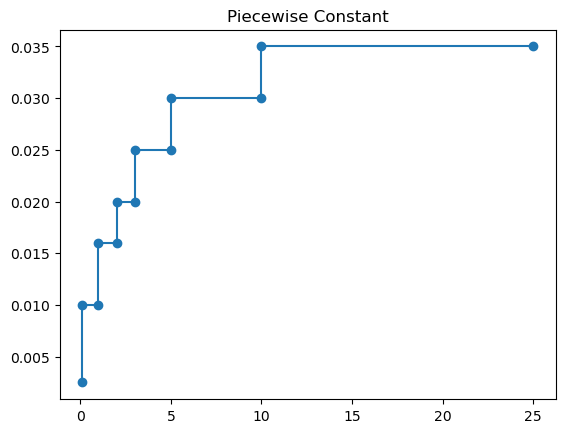

In [17]:
m = dict(zip(x, y))
m.update(dict(zip(x[:-1] + 1e-6, y[1:])))
k, v = zip(*sorted(m.items()))
plot(k, v, 'o-')
title('Piecewise Constant');

## Linear interpolation

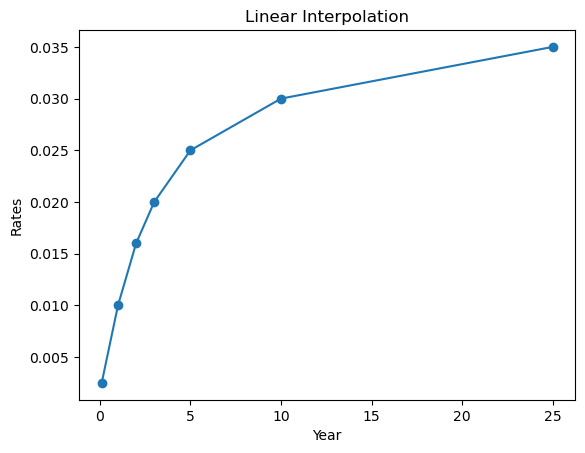

In [18]:
x = np.array([.1, 1.,2, 3., 5., 10., 25.])
y = np.array([.0025, .01, .016,.02, .025, .030, .035])
plot(x, y, '-o');
xlabel('Year')
ylabel('Rates');
title('Linear Interpolation');

## Polynomial interpolation

### Lagrange Polynomial

* Fit a polynomial function of order $n-1$ to the $n$ observations.
* The exact solution is known as the Lagrange polynomials:

$$ p(x) = \sum_{i=0}^n(\prod_{1\le j \le n, j\ne i}\frac{x-x_j}{x_i-x_j})y_i $$

It is rarely used in practice because it is hard (impossible) to control well the interpolation and the extrapolation may have an undesirable behavior.

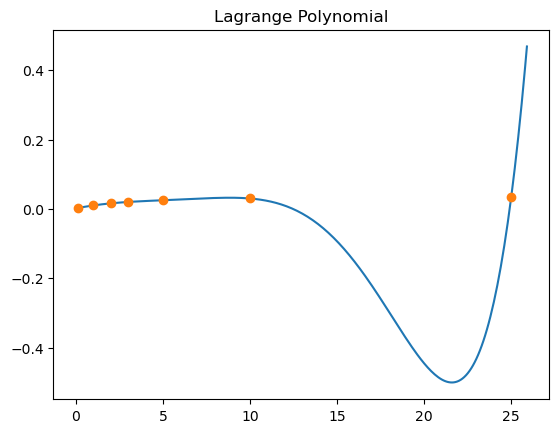

In [19]:
z = np.polyfit(x, y, len(x)-1)
p = np.poly1d(z)
x1d = arange(0, 26, .1)
plot(x1d, p(x1d))
plot(x, y, 'o');
title('Lagrange Polynomial');

### Hermite Interpolation

Hermite interpolation polynomials are built so that not only the (global) polynomial (of order $2n-1$ for $n$ points) can match given points $y_i$ at $x_i$ but also a given derivatives at these points, that is, $p(x_i) = y_i'$ where $y_i'$ are given.

In practice, when only points needs to be interpolated, Hermite interpolation offers more control on the shape of the interpolating curve thanks to the additional degrees of freedom from the given derivatives to match

Just like Lagrange polynomial, there nature being global (and are therefore sensitive to any input), they require a large order polynomial to fit many points leading to oscilating behavior.



## Spline interpolation

### Cubic spline

Cubic spline uses a 3rd order polynomial for each line section between knots

$$q_i(x) = a_i + b_i x + c_i x^2 + d_i x^3 \;,\;\; x_i < x < x_{i+1}$$ 

Enforce continuity up to the 2nd derivatives:

\begin{eqnarray}
q_{i-1}(x_i) &=& q_{i}(x_i) \\
q'_{i-1}(x_i) &=& q'_{i}(x_i) \\
q''_{i-1}(x_i) &=& q''_{i}(x_i)
\end{eqnarray}

#### Boundary conditions

For $n$ knots, there are $n-1$ line sections with $4(n-1)$ parameters
 * $n$ constraint for the hitting the $n$ knot values
 * 3 continuity constraints for each intermediate knot: $3(n-2)$ 
 * $4n-6$ constraints in total 
 
Two additional constraints required to uniquely determine the cubic spline:
 * Natural Spline: $q''_1(x_1) = q''_{n-1}(x_{n}) = 0$
 * End slope conditions (also called clamped boundary): $q'_1(x_1) = q'_0, \;\; q'_{n-1}(x_{n}) = q'_1$

### Equivalent definitions
One could have set
$$q_i(x) = a_i + b_i (x-x_i) + c_i (x-x_i)^2 + d_i (x-x_i)^3 $$ 
Or
$$q_i(x) = a_i + b_i \left(\frac{x-x_i}{x_{i+1}-x_i}\right) + c_i \left(\frac{x-x_i}{x_{i+1}-x_i}\right)^2 + d_i \left(\frac{x-x_i}{x_{i+1}-x_i}\right)^3$$

The coefficients $a_i, b_i, c_i$ would be different from one expression to the other, but matching beginning and end-points yields easy one-to-one relationships between each of them.


### Solving for Cubic Spline

Let's consider the form $q_i(x) = a_i + b_i (x-x_i) + c_i (x-x_i)^2 + d_i (x-x_i)^3 $.

Noting $\Delta x_i = x_{i-1} - x_i$, the $C^2$ constraints yield:
\begin{split}
q_{i+1}(x_{i+1}) &= a_{i+1} = a_i + b_i \Delta x_i + c_i (\Delta x_i)^2 + d_i (\Delta x_i)^3 \\
q_i'(x_i) &= b_i ; \;\;\; b_{i+1} = b_i + 2 c_i \Delta x_i + 3 d_i (\Delta x_i)^2 \\
q_i''(x_i) &= 2c_i ; \;\;\; c_{i+1} = c_i + 3 d_i \Delta x_i
\end{split}

From $q_i(x_i) = a_i$, we can consider that the $a_i$ are given.

Then the key obersation is to note the tri-diagnonal relationship between $c_i$ and $a_i$:
$$ \Delta x_{i-1} c_{i-1} + 2(\Delta x_{i-1} + \Delta x_i) c_i + \Delta x_i c_{i+1} = \frac{3}{\Delta x_i} (a_{i+1} - a_i) - \frac{3}{\Delta x_{i-1}} (a_i - a_{i-1}) $$

With the natural boundary condition, it comes $c_1 = c_n = 0$. The clamped condition is left as an exercise (and add 2 linear equations) to the interested student.

A tri-diagonal system is efficiently solved with the [Thomas Algorithm](https://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm).

Once the $a_i$ and $c_i$ are known, one easily gets:
$$ b_i = \frac{a_{i+1} - a_i}{\Delta x_i} + \Delta x_i \frac{2c_i + c_{i+1}}{3} $$
$$ d_i = \frac{c_{i+1} - c_i}{3\Delta x_i} $$



### Cubic spline examples

Spline interpolation is very smooth

However, it does not (always) preserve monotonicity and convexity 
  * it could overshoot
  * can result in arbitrages in many situations

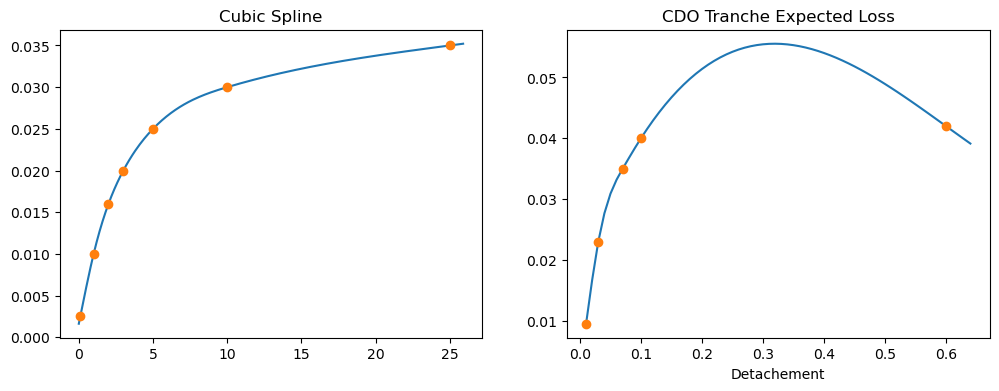

In [20]:
ts = interpolation_curve.RationalTension(0.)
ts.fit(x, y)

x2 = np.array([.01, .03, .07, .1, .6])
y2 = np.array([.0095, .023, .035, .040, .042])

figure(figsize=[12, 4])
subplot(1, 2, 1)
plot(x1d, ts.value(x1d))
plot(x, y, 'o');
title('Cubic Spline');

subplot(1, 2, 2)
ts.fit(x2, y2)
x2d = arange(.01, .65, .01)
plot(x2d, ts.value(x2d))
plot(x2, y2, 'o');
xlabel('Detachement')
title('CDO Tranche Expected Loss');

## Cubic Hermite Spline

<b>Monotonic</b> cubic spline are used to preserve monotonicity in of the input data

[Cubit Hermite Spline](https://en.wikipedia.org/wiki/Cubic_Hermite_spline)

[Monotonic Interpolation](https://en.wikipedia.org/wiki/Monotone_cubic_interpolation)

But need to specify a lot of extra parameter. Useful for very specific purposes.

## Tension Spline
A good compromise between extra number of parameters, shape-control, techincallity level and computation time.

### Exponential tension spline

A tension spline is originally defined as: $f^{(4)}(x) - \lambda f''(x) = 0$

* it models a physical spline stretched by a tension force 
* $\lambda$ is the ratio of the tension force over the rigidity of the spline
* it reduces to cubic spline when $\lambda = 0$
* with $\lambda \rightarrow \infty$, the spline is stretched to piece-wise straight lines
* the solution is a combination of exponential and linear functions of $x$
* developped in the 60's to eliminate undesirable inflexion points

## Rational tension spline

Generic tension spline has the following property:

* has a scalar tension parameter $\lambda$
* when $\lambda = 0$, it reduces to cubic spline
* it converges to piecewise linear interpolation uniformly as $\lambda$ increases 

Rational tension spline is a convenient form of generic tension spline:
$$ f(t) = \frac{a + bt + ct^2 + dt^3}{ 1 + \lambda t (1-t)} $$

* it is more tractable than the exponential tension spline as only polynomial functions are involved 
* solvable the same way as cubic spline, $\lambda$ is a known parameter

### Constraints

The rationale tension spline's values and derivatives at $t=0$ and $t=1$:
* Like cubic spline, there are $4(n-1)$ variables and constraints
* Solvable as a $4(n-1)$ dimensional linear systems ~ $O((4n)^3)$
* the four coefficients are fully determined by $f(0)$, $f(1)$, $\ddot{f}(0)$, $\ddot{f}(1)$

### Continuity conditions

Thus $\ddot{f}(x_i)$ at the knots are the only $n$ unknowns, which are solvable from the following $n$ constraints:
* End condition (natural spline): $\ddot{f}(x_1) = \ddot{f}(x_{n}) = 0$
* Continuity in $\dot{f}(x_i)$ for $n-2$ intermediate knots

Note that $f(\cdot)$ and its derivatives are continuous in $x$, not $t$:

$$
\frac{d^k f(t)}{dt^k} = (x_{i+1}-x_i)^k\frac{d^k f(x)}{dx^k} 
$$

* this is because $t = \frac{x-x_i}{x_{i+1} - x_i}$

### Integral

Complicated but analytic (use sympy or wolfram alpha) to get ...


### Limitation and Straightforward Extension
The parameter $\lambda$ is global when it is sometimes preferable to control it for each segment.
The proof above indicate how this is a readily available extension as the solving happens between each knot.

## Tension spline examples

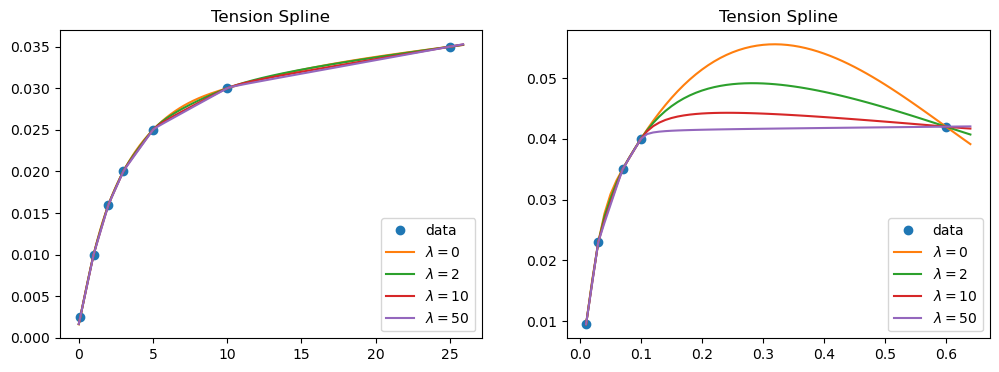

In [21]:
def plotTension(x, y, lbds, xd) :
    plot(x, y, 'o');
    title('Tension Spline');

    for lbd in lbds:
        ts = interpolation_curve.RationalTension(lbd)
        ts.fit(x, y)
        plot(xd, ts.value(xd))
    
    legend(['data'] + ['$\lambda = %.f$' % l for l in lbds], loc='best');

lbds = (0, 2, 10, 50)

figure(figsize=[12, 4])
subplot(1, 2, 1)
plotTension(x, y, lbds, x1d)
subplot(1, 2, 2)
plotTension(x2, y2, lbds, x2d)

# Parametric Representation

Parametric representation are ubiquitous in science, and therefore in finance.

A parametric representation is a function $x \to f(x,p)$ where $p = (p_1,...,p_N)$ are parameters. A simple example is a polynomial representation $f(x, p) = p_0 + p_1 x + p_2 x^2$.

Then for many observed points of the "true" function $f(x_i)$, one usually minimize an error functional, for instance but not limited to, something like 
$$ \min_{p} \sum_{i=1}^M w_i |f(x_i) - f(x_i, p)|^2 $$

Neural networks are a famous example of such representation and approach.



## Implied Volatility Smile and Variance Swap

A gentle introduction of main concepts. Many practical details not covered (but are easily learned on the field)

## Implied Volatility Parameterization

Each buy/sell-side firms trading options has its own in-house implied volatility parametric form used to fit (yet another optimization problem!) to market implied volatilities. This parametric form is then used as the in-house benchmark for all the related purposes (option marking, market making, exotic models calibration, etc.)

In the literature, the 
- SVI (stochastic Volatility)
- SABR formula**s**
- Itkin's sigmoid based parametric form

In practice, most parametric forms are in terms inspired/modifications/generalizations of these.

### SABR Formulas

The original formula is a benchmark in IR options to the point that most market-maker uses SABR parameters to quote their options.

The SABR model original consider a (forward) underlying with risk-neutral dynamic given by:
\begin{split}
dF_t &= \sigma_t F_t^{\beta} dW_t \\
d\sigma_t & = \nu \sigma_t dZ_t \\
\end{split}

with &\rho& being the correlation between $W_t$ and $Z_t$. Let's also note $F_0 = f$ and $\sigma_0 = \alpha$.<br>

Although the original formula from [Hagan et al.](http://janroman.dhis.org/finance/Volatilities/Volatility%20smile.pdf) (see also [here](https://en.wikipedia.org/wiki/SABR_volatility_model)) is not limited to $c(f) = f^{\beta}$ in the SDE of $F_t$, it is the main case used in pratice. The main result gives an approximation for the implied volatility at strike $K$ and maturity $T$ given by:
\begin{split}
I(T,K, f) &\sim \frac{\alpha}{(f K)^{(1-\beta)/2} \left(1+ \frac{(1-\beta)^2}{24} \ln^2(f/K) + \frac{(1-\beta)^4}{1920} \ln^4(f/K) \right)} \times \frac{z}{x(z)}\\
&\times \left( 1 + \left(\frac{(1-\beta)^2}{24} \frac{\alpha^2}{(fK)^{1-\beta}}  + \frac{1}{4} \frac{\alpha \beta \rho \nu}{(f K)^{(1-\beta)/2}} + \frac{2-3\rho^2}{24}\nu^2 \right) T \right) \\ \\
z &= \frac{\nu}{\alpha} (f K)^{(1-\beta)/2} \ln(f /K)\\
x(z)&= \ln \left(\ \frac{\sqrt{1-2\rho z} + z -\rho}{1-\rho} \right)
\end{split}

The limit as $K \to f$ gives
$$
I(T,f,f) \sim \frac{\alpha}{f^{1-\beta}}\left(1+ \left(\frac{(1-\beta)^2}{24}\frac{\alpha^2}{f^{2(1-\beta)}} + \frac{1}{4}\frac{\alpha \beta \rho \nu}{f^{1-\beta}} + \frac{2-3\rho^2}{24}\nu^2 \right)T \right)
$$

Later, other formulas were published, most notably from [Louis Paulot](https://arxiv.org/abs/0906.0658) and [Pierre Henry-Labordere](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=6986010.)

Other type of expansions exist:
- Volatility of Volatility (see for instance [Bergomi-Guyon](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1967470))
- various asymptotic regime (see for instance [BookAsymptoticMethodsInFinance](https://www.amazon.com/Deviations-Asymptotic-Proceedings-Mathematics-Statistics/dp/3319385127))

<div class="alert alert-block alert-danger">
These formulae are asymptotic expansion when $t \to 0$. In particular, if you use an MC pricer to compute the implied volatility and compare to the analytic approximation, you will easily observe an obvious difference.
    
In practice, these formulae are used as parametric form only, but have some stochatic volatility modeling background which can be helpful to draw some intuition on the behavior of the parametric form, the risk profiles it can produce, etc.
</div>

<div class="alert alert-block alert-danger">
The SVI as well as the SABR formulas can generate (numerical) arbitrages. In practice, additional controls are needed when fitting these formulas to market option prices.
</div>

### SVI (Stochastic Volatility Inspired)

The [SVI](https://arxiv.org/pdf/1204.0646.pdf) parameterization is the standard benchmark for equity options smile parametrisation. Another good reference is [SVIModelFreeWings](https://hal.science/hal-02517572/document).

You can just read the paper but for self-consistency, let's recall some notation:
- The forward $F_t = E(S_t)$
- The log-moneyness $k:=\ln(K/F_t) \Leftrightarrow K = F_t e^k $
- The total variance $w(k,t) = \sigma_{BS}^2(t,k)t$ where $\sigma_{BS}(t,k) = IV(t, F_t e^k)$

#### Raw SVI
The first version of the SVI parameterisation, called the **raw-SVI** is given by:
$$
w(k,t) = a + b\left(\rho(k-m) + \sqrt{(k-m)^2 + \sigma^2} \right)
$$
where $(a,b,\rho,m, \sigma)$ for $a \in \mathbb{R}^+$, $b\geq 0$, $|\rho| < 1$ and $\sigma >0$ are the parameters to be fitted to options prices. In addition, we need (at the very least) $a+b\sigma\sqrt{1-\rho^2} \geq 0$.

#### Natural SVI
A useful extension is the **natural SVI** given by:
$$
w(k,t) = \Delta + \frac{\omega}{2} \left(1 + \zeta \rho (k-\mu) + \sqrt{ (\zeta(k-\mu) + \rho)^2 + (1-\rho^2)} \right)
$$

for $\Delta \in \mathbb{R}$, $\omega \geq 0$, $\mu \in \mathbb{R}$, $|\rho| <1$ and $\zeta >0$. There is a one to one mapping from raw-SVI to natural-SVI.

####  SVI-SABR
This parameterization resemble to that of SABR $(\beta=1)$ with an SVI flavor directly applied on the implied variance
$$
\sigma_{bs}^2(k) = \frac{\alpha^2}{2} \left(1 + \rho k \frac{\nu}{\alpha} + \sqrt{\left(\frac{\nu}{\alpha}k+\rho \right)^2 + (1-\rho^2)} \right)
$$

which has the important advantage over the SABR parameterization that the SVI-SABR had no butterfly arbitrage
if $\alpha \nu (1+|\rho|) < 4$  and $\nu^2(1+|\rho|)<4$.

#### SVI-Jump-Wings (SVI-JW)

The **SVI Jump-Wings (SVI-JW)** aims at finding parameters that will be more stable over time as they have an easy geometric interpretation:

\begin{split}
\s_{bs}^2 &= \frac{a + b\left(-\rho m  + \sqrt{\s^2 + m^2}\right)}{T}\\
\psi &= \frac{1}{\s_{bs} \sqrt{T}}\frac{b}{2}\left( -\frac{m}{\sqrt{m^2 + \s^2}{}} +\rho\right) \\
p &= \frac{1}{\s_{bs} \sqrt{T}}b(1-\rho)\\
c &= \frac{1}{\s_{bs} \sqrt{T}}b(1+\rho)\\
\s_{min} &= \frac{1}{T} \left(a + b \s\sqrt{1-\rho^2} \right) \\
\end{split}

where
* $\s^2_{bs} = \s^2_{bs}(0,T)$ is the ATM variance
* $\psi$ is the ATM Skew.
* $p$ and $c$ are the slope of the put and call wings.
* $\s_{min}$ is the minimum implied volatility

#### Itkin's Sigmoid Based model

[Itkin's](https://arxiv.org/abs/1407.0256) implied volatility model is written as:

\begin{split}
w(z)&= w_c + \mathcal{S}_C \frac{y}{1+y^2} + F(y) \sqrt{T} \sum_{k=1}^n a_k G(y)^k \\
G(y) &= \alpha_p^{-1} \varphi(-\alpha_p y) 1_{\{y<\leq 0 \}} + \alpha_c^{-1} \varphi(-\alpha_c y) 1_{\{y > 0 \}} \\
y &= z - m \\
z &= k/ \sqrt{T} \\
\end{split}

and $\varphi(x)$ is a sigmoid function (i.e. it tends to some constant at both ends when the argument x tends to $\pm \infty$ , and vanish at x = 0.) function, e.g. $\varphi(x) = x / \sqrt{1+x^2}$.

The function $F(y)$ defines the model behavior at wings. It could be chosen in such a way that close to $y = 0$ we have $F(y) \sim |y|^{\alpha_0}$ while $F(y) \to y \alpha_+$  as $y\to + \infty$, and $F(y) \to (−y)\alpha_-$ , as $y \to -\infty$ where $0 < \alpha_− ≤ 1$, $0 < \alpha_+ ≤ 1$, $0 < \alpha_0$ are some constants.
This construction is accounting for both linear and sublinear behavior of the regression at
wings. A common choice is $F(y) ≡ |y|$.

It is an adaptative parametric model where the number of parameters increases as needed by choosing a higher $n$.


### Shape Raw SVI

In [22]:
# auxiliary function
def totalVarToVol(w,t):
    if w <= 0. or t < -1e-10:
        return 0.
    return np.sqrt(w/t)

In [23]:
def SVI(k, a,b,rho,m, sigma):
    # unsafe implementation - no check for parameters validity
    if a+b*sigma*np.sqrt(1.-rho*rho) <= 0.:
        return 0.  # could coded inside a class with a minVariance member set to 1e-10 by default
    k_m = k-m
    return a + b*(rho*k_m + np.sqrt(k_m*k_m+sigma*sigma))

In [24]:
def plotSVI(params, K = np.arange(0.1, 3., 0.01)):
    logStrikes = np.log(K)
    a = params.get('a', 0.2*0.2)
    b = params.get('b', 0.1)
    rho = params.get('rho', -0.8)
    m = params.get('m',-0.01)
    sigma = params.get('sigma',0.3)
    t = params.get('t',0.5)
    volSVI = [totalVarToVol(w,t) for w in [SVI(k, a,b,rho,m, sigma) for k in logStrikes]]
    plot(K, volSVI)
    xlabel('moneyness')
    ylabel('implied vol')

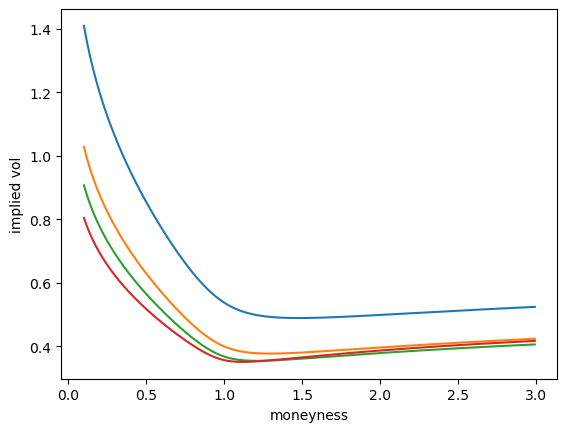

In [25]:
a = 0.2
params_3m = dict(a = a*a,
                 b = 0.11,
                 rho = -0.8,
                 sigma= 0.3, 
                 m=-0.01,
                 t=0.25)
plotSVI(params_3m)

a=0.225
params_6m = dict(a = a*a,
                 b = 0.12,
                 rho = -0.73,
                 sigma= 0.25, 
                 m=-0.01,
                 t=0.5)
plotSVI(params_6m)

a=0.27
params_9m = dict(a = a*a,
                 b = 0.14,
                 rho = -0.69,
                 sigma= 0.21, 
                 m=-0.01,
                 t=0.75)
plotSVI(params_9m)

a=0.32
params_12m = dict(a = a*a,
                  b = 0.15,
                  rho = -0.58,
                  sigma= 0.17, 
                  m=-0.01,
                  t=1.)
plotSVI(params_12m)


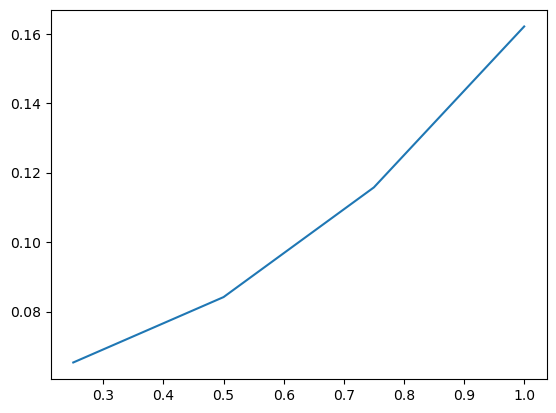

In [26]:
def svi(k, params):
    return SVI(k, params['a'], params['b'], params['rho'], params['m'], params['sigma'])

T = [0.25, 0.5, 0.75, 1.]
k = 0.9
total_var = [svi(k, params_3m),svi(k, params_6m),svi(k, params_9m),svi(k, params_12m)]
plot(T, total_var)

Text(0.5, 1.0, 'Raw SVI - effect of sigma')

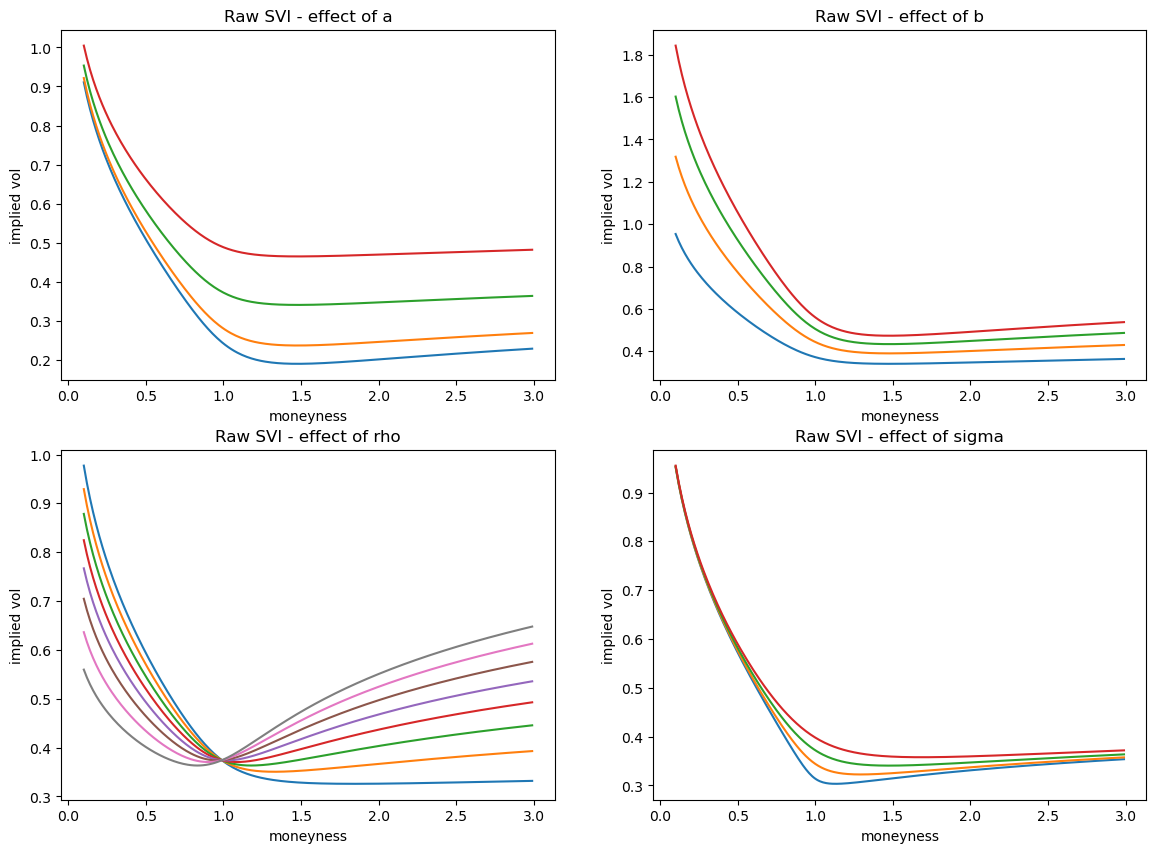

In [27]:
fig = figure(figsize=[14, 10])

subplot(2, 2, 1)
# effect of a
for a in [(i/10.)**2 for i in range(4)]:
    params = dict(a = a)
    plotSVI(params)
title('Raw SVI - effect of a')

subplot(2, 2, 2)
# effect of b
for b in [(i+1)/10. for i in range(4)]:
    params = dict(b = b)
    plotSVI(params)    
title('Raw SVI - effect of b')

subplot(2, 2, 3)
# effect of rho
for rho in [-0.9 + (2*i)/10. for i in range(8)]:
    params = dict(rho = rho)
    plotSVI(params)
title('Raw SVI - effect of rho')

subplot(2, 2, 4)
# effect of sigma
for sigma in [(i+1)/10. for i in range(4)]:
    params = dict(sigma = sigma)
    plotSVI(params)
title('Raw SVI - effect of sigma')

<div class="alert alert-block alert-warning">
One issue of the raw SVI parameterization, even if arbitrages are excluded during the optimization step, is the lack of orthogonality in the parameters space:<br>
- $\rho$ affect both the ATM skew and the slope of the right wing <br>
- $a$ and $b$ have similar effects on the ATM and opposite the right wing slope levels
</div>

## Variance Swaps

A variance swap (on Index) is a swap exchanging
$$ \frac{252}{N} \sum_{i=1}^N \log^2(S_{t_i}/S_{t_{i-1}}) - K_{var}^2 $$

where $N$ is the number of business days between $t_0$ and $t_N=T$, observation are daily on close.<br>

Remark: on stocks, most variance swaps are capped and dividend adjusted: the payoff is instead $\log^2\left(\frac{S_{t_i}}{S_{t_-1}(1+div(t_{i-1}, t_i))}\right)$<br>

A classical result on quadratic version in a Brownian Motion setting gives in the limit of higher frequency of observations:
$$ \lim_{k \to \infty} \frac{1}{k} \sum_{i=1}^k \log^2(S_{t^{(k)}_i}/S_{t^{(k)}_-1}) = \int_0^T d<\ln(S)>_t $$

It is standard to then approximate (in standard models)
$$ \sum_{i=1}^N \log^2(S_{t_i}/S_{t_-1}) \sim \int_0^T d<\ln(S)>_t = \int_0^T \sigma_t^2 dt $$

Since there is approximatively 252 business day in one year, we see that $\frac{252}{N}\sim \frac{1}{T}$ when $T$ is expressed in years. In practice, the ratio $\frac{252}{N}$ is computed exactly as for instance when the maturity 2 years, we might not exactly have $\frac{252}{N} = 2$. Although it would be close, when scaled by millions (billions?) of notional, this difference can become quite sizeable.

Assume a model of the form (with all the nice assumptions needed, and in particular no jumps)
$$ dS_t = S_t ((r_t-q_t) dt + \sigma_t dW_t) $$

Then applying Ito's formula yields:
\begin{split}
\ln(S_T) &= \ln(S_0) + \int_0^T \frac{dS_t}{S_t} - \frac{1}{2} \int_0^T \sigma_t^2 dt \\
\ln(S_T) &= \ln(S_0) + \int_0^T (r_t-q_t) dt  + \int_0^T \sigma_t dW_t - \frac{1}{2} \int_0^T \sigma_t^2 dt \\
&= \ln(E(S_T)) + \int_0^T \sigma_t S_t dW_t - \frac{1}{2} \int_0^T \sigma_t^2 dt 
\end{split}
Then we have
$$ E\left(\int_0^T \sigma_t^2 dt \right) = -2 E(\log(S_T/E(S_T))) $$ 

Besides from the formula:
$$ E(f(S_T)) = f(E(S_T)) + \int_0^{E(S_T)} f''(K) E[(K-S_T)^+] dK + \int_{E(S_T)}^{+\infty} f''(K) E[(S_T-K)^+] dK $$
we get
$$ E(\ln(S_T)) = \ln(E(S_T)) - \int_0^{E(S_T)} \frac{1}{K^2} E[(K-S_T)^+] dK - \int_{E(S_T)}^{+\infty} \frac{1}{K^2} E[(S_T-K)^+] dK $$

This finally gives (for undiscounted option price):
$$ E\left(\int_0^T \sigma_t^2 dt \right) =2 \int_0^{E(S_T)} \frac{1}{K^2} P(K, IV(T, K)) dK + 2 \int_{E(S_T)}^{+\infty} \frac{1}{K^2} C(K, IV(T, K))dK $$

where $IV(T,K)$ is the implied volatiltiy of maturity $T$ and strike $K$.

### Variance swap pricing and hedging

In pratice, the implied volatility surface is fitted with a parametric form, and then the variance swap pricing integral is computed numerically.

Although some underlying (e.g. S&P 500) have liquid options on a large range of strikes, there is only a finite amount, and for hedging purposes, the hedging of variance requires to essentially have a strip of liquid market options:
\begin{split}
\frac{1}{2}E\left(\int_0^T \sigma_t^2 dt \right) &= \int_0^{E(S_T)} \frac{1}{K^2} P(K, IV(T, K)) dK + \int_{E(S_T)}^{+\infty} \frac{1}{K^2} C(K, IV(T, K))dK \\
& \approx \int_{K_{min}}^{F}\frac{1}{K^2} P(K, IV(T, K)) dK + \int_F^{K_{max}} \frac{1}{K^2} C(K, IV(T, K)) dK \\
& \approx \sum_{K_{min} \leq K_i < F} \frac{1}{K_i^2} P(K_i, IV(T, K_i)) (K_{i+1} - K_i) + \sum_{F \leq K_i < K_{max}} \frac{1}{K_i^2} C(K_i, IV(T, K_i)) (K_{i+1} - K_i)
\end{split}

Then the residual delta between variance swap and the strip of options is then delta hedged dynamically.

Building the options strip for variance swaps can be done in many ways. From $\int_a^b \frac{1}{x^2} dx = \frac{b-a}{ab}$ one could have (writing $K_{min} = K_0$ and $K_{max} = K_N$ and dropping the $IV(T, K)$ for clarity in the notation):

\begin{split}
\frac{1}{2}E\left(\int_0^T \sigma_t^2 dt \right) &= \int_0^{E(S_T)} \frac{1}{K^2} P(K) dK + \int_{E(S_T)}^{+\infty} \frac{1}{K^2} C(K)dK \\
& = \int_0^{K_0} \frac{1}{K^2} P(K)) dK + \int_F^{K_N} \frac{1}{K^2} C(K) dK + \int_{K_N}^{+\infty} \frac{1}{K^2} C(K) dK \\
& = \int_0^{K_0} \frac{1}{K^2} P(K) dK + \sum_{K_i < F} \int_{K_i}^{K_{i+1}} \frac{1}{K^2} P(K) dK + \sum_{F \leq K_i < K_{max}} \int_{K_i}^{K_{i+1}} \frac{1}{K^2} C(K) dK + \int_{K_N}^{+\infty} \frac{1}{K^2} C(K) dK
\end{split}




The classical approximation first presented above amounts to neglecting the integral on the wings, but we could control them and choose or not if the approximations is cost efficient (by comparing the difference between approximation and theoretical value to the transaction costs as bid/ask spreads are higher for out of the money options):
$$\int_0^{K_0} \frac{1}{K^2} P(K) dK \approx \frac{K_0 - 0}{2} \left(\frac{P(K_0)}{K_0^2} + \lim_{K\to0} \frac{P(K)}{K^2} \right)  = \frac{P(K_0)}{2K_0} $$
$$ \int_{K_N}^{+\infty} \frac{1}{K^2} C(K) dK \approx C(K_N) \int_{K_N}^{+\infty} \frac{1}{K^2} dK = \frac{C(K_N)}{K_N} $$

Or we can match the vegas (which can be computed numerically for the integral part):
$$\int_0^{K_0} \frac{1}{K^2} P(K) dK \approx  \frac{\partial_{I(K_0)}\left(\int_0^{K_0} \frac{1}{K^2} P(K) dK \right)}{\partial_{I(K_0)} P(K_0)}P(K_0) $$
$$ \int_{K_N}^{+\infty} \frac{1}{K^2} C(K) dK \approx C(K_N) \int_{K_N}^{+\infty} \frac{1}{K^2} dK = \frac{C(K_N)}{K_N} $$

<div class="alert alert-block alert-info">
Although in practice, the simplest one is often used as the benchmark. <p>
Being able to have different (yet trying to achieve the same goal) hedging strategies is useful for several reasons: <p>
- enable one to validate numerical stability (especially when something goes wrong);<p>
- provide different cost efficiency trade-offs; <p>
- can provide different insight from their performance in back-testing.<p>
</div>